In [10]:
%pip install arabic-stopwords

Note: you may need to restart the kernel to use updated packages.


In [11]:
import pandas as pd
import nltk
import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.isri import ISRIStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
from sklearn.svm import SVC
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split, GridSearchCV
import arabicstopwords.arabicstopwords as ast
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import torch
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from collections import OrderedDict
import matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.preprocessing import OneHotEncoder

In [12]:
dataset = load_dataset('emotone_ar')

  0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
def normalizeArabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)

    return(text)

stop_words = ast.stopwords_list()

def remove_stop_words(text):
    return ' '.join(word for word in str(text).split() if word not in stop_words)

arabic_punctuations = '''`÷×؛<>_():*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations

def remove_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)


# snow_stemmer = SnowballStemmer(language='arabic')
isri_stemmer = ISRIStemmer()

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
def stemming(text):
  x = w_tokenizer.tokenize(text)
  # return [snow_stemmer.stem(w) for w in x]
  return [isri_stemmer.stem(w) for w in x]

def prepare_text(text):
  text = normalizeArabic(text)
  text = remove_stop_words(text)
  text = remove_punctuations(text)
  text = stemming(text)
  return text

In [14]:
df = pd.DataFrame(dataset['train'])

In [15]:
df.head()

,tweet,label
0,الاوليمبياد الجايه هكون لسه ف الكليه ..,0
1,عجز الموازنه وصل ل93.7 % من الناتج المحلي يعني...,1
2,كتنا نيله ف حظنا الهباب xD,3
3,جميعنا نريد تحقيق اهدافنا لكن تونس تالقت في حر...,2
4,الاوليمبياد نظامها مختلف .. ومواعيد المونديال ...,0


In [16]:
df.isnull().sum()

tweet    0
label    0
dtype: int64

In [17]:
df['label'].value_counts()

0    1550
1    1444
2    1281
3    1256
4    1220
7    1207
5    1062
6    1045
Name: label, dtype: int64

In [18]:
g = df.groupby('label')
df_balanced = g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True))
df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)

In [19]:
df_balanced['original'] = df_balanced['tweet']
df_balanced['data'] = df_balanced['original'].apply(prepare_text)
df_balanced = df_balanced.drop(['tweet'], axis=1)

In [20]:
df_balanced['label'].value_counts()

0    1045
3    1045
6    1045
7    1045
5    1045
4    1045
2    1045
1    1045
Name: label, dtype: int64

<Axes: ylabel='Frequency'>

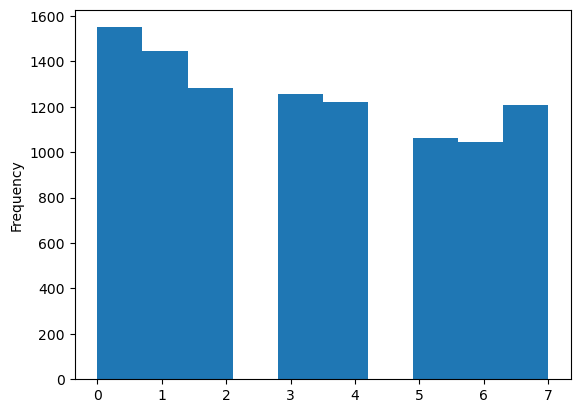

In [21]:
df['label'].plot.hist()

<Axes: ylabel='Frequency'>

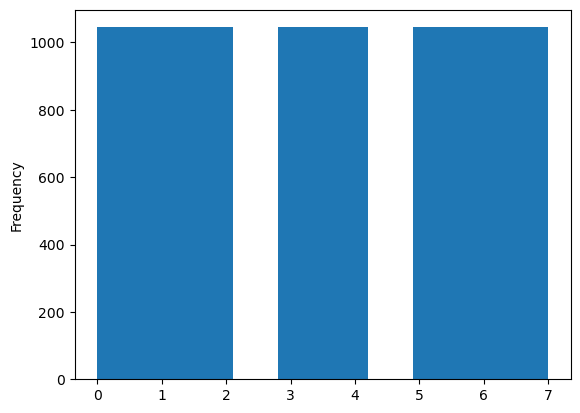

In [22]:
df_balanced['label'].plot.hist()

In [23]:
X_train, X_val, y_train, y_val = train_test_split(df_balanced['data'], df_balanced['label'], test_size=0.2, stratify=df_balanced['label'], random_state=42)

In [24]:
encoder = OneHotEncoder()

y_train = encoder.fit_transform(y_train.values.reshape(-1,1)).toarray()
y_val = encoder.transform(y_val.values.reshape(-1,1)).toarray()

In [25]:
def prepare_tokenization(train, val, test=None, pad=500):
  tokenizer = Tokenizer(oov_token='<UNK>')
  tokenizer.fit_on_texts(train)
  tokenizer.word_index['<PAD>'] = 0
  train = tokenizer.texts_to_sequences(train)
  val = tokenizer.texts_to_sequences(val)
  if not pad==False:
    train = sequence.pad_sequences(train, maxlen=pad)
    val = sequence.pad_sequences(val, maxlen=pad)
  if not type(test)==type(None):
    test = tokenizer.texts_to_sequences(test)
    if not pad==False:
      test = sequence.pad_sequences(test, maxlen=pad)
  v_size = len(tokenizer.word_index)
  print("Vocabulary size={}".format(v_size))
  print("Number of Documents={}".format(tokenizer.document_count))
  if not type(test)==type(None):
    return v_size, train, val, test
  else:
    return v_size, train, val

In [26]:
VOCAB_SIZE, train_sequences, val_sequences = prepare_tokenization(X_train, X_val, pad=False)

Vocabulary size=10218
Number of Documents=6688


(array([ 167.,  932., 1228., 1176., 1099., 1083.,  774.,  200.,   27.,
           2.]),
 array([ 0.,  3.,  6.,  9., 12., 15., 18., 21., 24., 27., 30.]),
 <BarContainer object of 10 artists>)

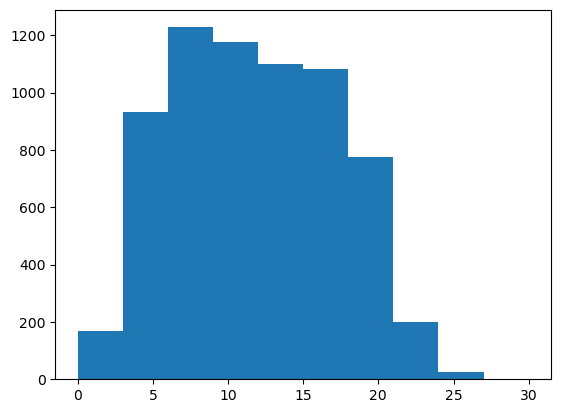

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
plt.hist(train_lens)

In [28]:
max_length = max(train_lens)

In [29]:
max_length

30

In [30]:
X_train = sequence.pad_sequences(train_sequences, maxlen=max_length)
X_val = sequence.pad_sequences(val_sequences, maxlen=max_length)
X_train.shape, X_val.shape

((6688, 30), (1672, 30))

In [31]:
BATCH_SIZE = 128
EPOCHS = 50
EMBED_SIZE = 300
LEARNING_RATE =  0.001

early_stopping_monitor = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=10,
    verbose=0,
    mode='max',
    baseline=None,
    restore_best_weights=True)

In [32]:
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=max_length, trainable=True))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(512, return_sequences=True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256, return_sequences=True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=False)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))
opt = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

history = model.fit(X_train, np.asarray(y_train), validation_data=(X_val, np.asarray(y_val)), batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[early_stopping_monitor])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 300)           3065400   
                                                                 
 bidirectional (Bidirectiona  (None, 30, 1024)         2500608   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 30, 512)          1969152   
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              493056    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                        

In [34]:
model1 = Sequential()
model1.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=max_length, trainable=True))
model1.add(tf.keras.layers.GRU(512, return_sequences=True))
model1.add(tf.keras.layers.GRU(256, return_sequences=True))
model1.add(tf.keras.layers.GRU(128, return_sequences=False))
model1.add(Dense(128, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(8, activation='softmax'))
opt1 = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model1.compile(loss='categorical_crossentropy', optimizer=opt1, metrics=['accuracy'])
model1.summary()

history = model1.fit(X_train, np.asarray(y_train), validation_data=(X_val, np.asarray(y_val)), batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[early_stopping_monitor])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 30, 300)           3065400   
                                                                 
 gru_3 (GRU)                 (None, 30, 512)           1250304   
                                                                 
 gru_4 (GRU)                 (None, 30, 256)           591360    
                                                                 
 gru_5 (GRU)                 (None, 128)               148224    
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)               

In [38]:
model2 = Sequential()
model2.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=max_length, trainable=True))
model2.add(tf.keras.layers.GRU(128, return_sequences=False))
model2.add(Dropout(0.5))
model2.add(Flatten())
model2.add(Dense(8, activation='softmax'))
opt2 = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model2.compile(loss='categorical_crossentropy', optimizer=opt2, metrics=['accuracy'])
model2.summary()

history = model2.fit(X_train, np.asarray(y_train), validation_data=(X_val, np.asarray(y_val)), batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[early_stopping_monitor])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 30, 300)           3065400   
                                                                 
 gru_6 (GRU)                 (None, 128)               165120    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 8)                 1032      
                                                                 
Total params: 3,231,552
Trainable params: 3,231,552
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
53/53 [==========================

In [40]:
model3 = Sequential()
model3.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=max_length, trainable=True))
model3.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=False)))
model3.add(Dropout(0.5))
model3.add(Flatten())
model3.add(Dense(8, activation='softmax'))
opt3 = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model3.compile(loss='categorical_crossentropy', optimizer=opt3, metrics=['accuracy'])
model3.summary()

history = model3.fit(X_train, np.asarray(y_train), validation_data=(X_val, np.asarray(y_val)), batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[early_stopping_monitor])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 30, 300)           3065400   
                                                                 
 bidirectional_3 (Bidirectio  (None, 256)              330240    
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 flatten_1 (Flatten)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 3,397,696
Trainable params: 3,397,696
Non-trainable params: 0
____________________________________________

In [42]:
model4 = Sequential()
model4.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=max_length, trainable=True))
model4.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=False)))
model4.add(Dropout(0.5))
model4.add(Dense(64, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(8, activation='softmax'))
opt4 = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model4.compile(loss='categorical_crossentropy', optimizer=opt4, metrics=['accuracy'])
model4.summary()

history = model4.fit(X_train, np.asarray(y_train), validation_data=(X_val, np.asarray(y_val)), batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[early_stopping_monitor])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 30, 300)           3065400   
                                                                 
 bidirectional_4 (Bidirectio  (None, 256)              330240    
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 64)                16448     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 8)                 520       
                                                      

In [36]:
predictions = model.predict(X_val)
print(classification_report(y_val.argmax(axis=1), predictions.argmax(axis=1)))

53/53 [==============================] - 2s 10ms/step
              precision    recall  f1-score   support

           0       0.54      0.54      0.54       209
           1       0.58      0.49      0.53       209
           2       0.41      0.39      0.40       209
           3       0.38      0.33      0.35       209
           4       0.63      0.70      0.67       209
           5       0.77      0.79      0.78       209
           6       0.42      0.51      0.46       209
           7       0.89      0.89      0.89       209

    accuracy                           0.58      1672
   macro avg       0.58      0.58      0.58      1672
weighted avg       0.58      0.58      0.58      1672



In [37]:
predictions1 = model1.predict(X_val)
print(classification_report(y_val.argmax(axis=1), predictions1.argmax(axis=1)))

53/53 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.53      0.53      0.53       209
           1       0.54      0.58      0.56       209
           2       0.52      0.32      0.40       209
           3       0.33      0.43      0.37       209
           4       0.67      0.65      0.66       209
           5       0.77      0.79      0.78       209
           6       0.36      0.37      0.37       209
           7       0.87      0.88      0.87       209

    accuracy                           0.57      1672
   macro avg       0.57      0.57      0.57      1672
weighted avg       0.57      0.57      0.57      1672



In [39]:
predictions2 = model2.predict(X_val)
print(classification_report(y_val.argmax(axis=1), predictions2.argmax(axis=1)))

53/53 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.55      0.65      0.59       209
           1       0.58      0.66      0.62       209
           2       0.47      0.47      0.47       209
           3       0.36      0.32      0.34       209
           4       0.70      0.77      0.74       209
           5       0.76      0.81      0.79       209
           6       0.46      0.33      0.38       209
           7       0.95      0.90      0.92       209

    accuracy                           0.61      1672
   macro avg       0.60      0.61      0.61      1672
weighted avg       0.60      0.61      0.61      1672



In [43]:
predictions3 = model3.predict(X_val)
print(classification_report(y_val.argmax(axis=1), predictions3.argmax(axis=1)))

53/53 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.57      0.69      0.63       209
           1       0.59      0.56      0.57       209
           2       0.42      0.46      0.44       209
           3       0.39      0.40      0.40       209
           4       0.74      0.66      0.70       209
           5       0.77      0.80      0.78       209
           6       0.48      0.40      0.43       209
           7       0.93      0.91      0.92       209

    accuracy                           0.61      1672
   macro avg       0.61      0.61      0.61      1672
weighted avg       0.61      0.61      0.61      1672



In [44]:
predictions4 = model4.predict(X_val)
print(classification_report(y_val.argmax(axis=1), predictions4.argmax(axis=1)))

53/53 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.51      0.74      0.61       209
           1       0.57      0.65      0.60       209
           2       0.43      0.41      0.42       209
           3       0.32      0.30      0.31       209
           4       0.74      0.65      0.69       209
           5       0.75      0.83      0.79       209
           6       0.53      0.32      0.40       209
           7       0.95      0.89      0.92       209

    accuracy                           0.60      1672
   macro avg       0.60      0.60      0.59      1672
weighted avg       0.60      0.60      0.59      1672

